<a href="https://colab.research.google.com/github/Michwynn/London-Airbnb-Analysis---2/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We use the cleaned up labelled data to build the Sequence model.
We prefer using the bidirectional LSTM because:

*  LSTM model help us capture long range dependencies in the sentences
*  A Bidirectional LSTM model allows us to use information about the prior words and the subsequent words





In [ ]:
### 1. Import all the required libraries
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
### 2. Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content


In [ ]:
%cd /content/drive/MyDrive/Airbnb_Milestone2/Datasets/Train_Val_Test

/content/drive/MyDrive/Airbnb_Milestone2/Datasets/Train_Val_Test


For our deep learning models, we will be using the same underwriting data which was created by Michael for his machine learnign models

In [ ]:
### 3. Using the undersampled data created by Michael ### 48555 rows
data_cleaned = pd.read_csv('cleaned_df_undersampling.csv', lineterminator = '\n')
display(data_cleaned.sample(2))

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,listing_id,id,date,reviewer_id,reviewer_name,comments,lang,cleaned_comments,cleaned_comments_nltk,VADER_compound_score,sentiment,review_length
31,315539,315539,345007,18591406,486950354,2019-07-13,45423592,Donovan,"Great value for money, very comfortable and cl...",en,great value comfortable close excellent transport,"['great', 'value', 'money', 'comfortable', 'cl...",0.93,Positive,14
3180,957937,957937,1069662,16629490,185691851,2017-08-22,57375586,Valdi,I stayed there for 18 nights and had a pretty ...,en,i stayed nights pretty good the room clean bat...,"['stayed', 'night', 'pretty', 'good', 'stay', ...",0.96,Positive,133


In [ ]:
#### 4. Split the data into Train-Val-Test. Again using the same seeds as used by Michael
def get_train_val_test(df, fractions, RANDOM_SEED):
  # Get the required input and target variables from dataframe and drop NA rows:
  df = df[['comments','sentiment', 'listing_id', 'id']].dropna()
  # shuffling the data:
  df = df.sample(frac = 1, random_state = RANDOM_SEED)
  # split into training, validation and testing sets
  train_df, val_df, test_df = np.array_split(df, (fractions[:-1].cumsum() * len(df)).astype(int))
  if len(train_df) + len(val_df) + len(test_df) != len(df):
    print("Check the splitting method!")
  else:
    return train_df, val_df, test_df

RANDOM_SEED = 42
fractions = np.array([0.8, 0.1, 0.1])
train_df, val_df, test_df = get_train_val_test(data_cleaned, fractions, RANDOM_SEED)



In [ ]:
### 5. Creating numeric labels 
labels_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
def label_creation(column):
  if column == 'Positive':
    label = 2
  elif column == 'Neutral':
    label = 1
  elif column == 'Negative':
    label = 0
  else:
    label = 999
  return label

train_df['label'] = train_df['sentiment'].apply(label_creation)
val_df['label'] = val_df['sentiment'].apply(label_creation)
test_df['label'] = test_df['sentiment'].apply(label_creation)

In [ ]:
print(train_df.groupby('label')['comments'].count())
print('**************************************')
print(val_df.groupby('label')['comments'].count())
print('**************************************')
print(test_df.groupby('label')['comments'].count())

label
0    13010
1    12902
2    12932
Name: comments, dtype: int64
**************************************
label
0    1614
1    1598
2    1643
Name: comments, dtype: int64
**************************************
label
0    1561
1    1685
2    1610
Name: comments, dtype: int64


### Beginning the data cleaning steps

Removing the HTML tags and carriage returns (\r)

In [ ]:
#### 6. Lets first remove html tags and \r
def rem_html(comment):
  comment = re.sub('<[^<]+?>', ' ', comment)
  comment = re.sub('\\r', ' ', comment)
  return comment
 

In [ ]:
train_df['cleaned_comments_LSTM'] = train_df['comments'].apply(rem_html)
val_df['cleaned_comments_LSTM'] = val_df['comments'].apply(rem_html)
test_df['cleaned_comments_LSTM'] = test_df['comments'].apply(rem_html)

Correcting the Spelling. Incorrect spelling of a word would cause issues in identifying the correct embedding vector for a word (From the pretrained embedding vector)

In [ ]:
#### 7. Lets do a spell check and try to correct the spellings. Presence of incorrect spelling causes issues in identifying the correct embeddings
########7.1 Install Jamspell
!apt-get install swig3.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig3.0 is already the newest version (3.0.12-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


In [ ]:
!pip install jamspell 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
### 7.2 This should be your working directory. Moving to my working drive
%cd /content/drive/MyDrive/Milestone2_codes/

/content/drive/MyDrive/Milestone2_codes


In [ ]:
import jamspell

corrector = jamspell.TSpellCorrector()
corrector.LoadLangModel('en.bin')

True

In [ ]:
########7.3 Apply spell check to each row. This takes around 6 min 35 sec
def spell_check(comment):
  corrected_spell = corrector.FixFragment(comment)
  return corrected_spell

In [ ]:
train_df['cleaned_comments_LSTM'] = train_df['cleaned_comments_LSTM'].apply(spell_check)
val_df['cleaned_comments_LSTM'] = val_df['cleaned_comments_LSTM'].apply(spell_check)
test_df['cleaned_comments_LSTM'] = test_df['cleaned_comments_LSTM'].apply(spell_check)

### Download the Pretrained Glove Word embedding model (trained by Stanford University)
It has a vocabulary of 400K words and is trained on 6 Billion tokens

In [ ]:
#### Download the pre-trained GloVe word embedding model trained by Stanford University
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2022-10-24 12:26:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-24 12:26:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-24 12:26:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.10’

g

The pretrained GloVe word embeddings has the option to use 50, 100, 200, 300 dimensional vectors. We tested different dimension vectors and finally choose to use the 300-D vectors. 
There are 400K words in the vocabulary 

In [ ]:
## The archive contains 50, 100, 200 and 300 dimensional vectors. We will use the 300 dimensional vector
embeddings_index = {}
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
### Computing the average value of the embedding vector. Will come useful during imputations for words which are from outside the vocabulary
avg_embedding_vector = sum(embeddings_index.values())/len(embeddings_index)  

In [ ]:
#### Tokenize the comments of the train data to create the Vocabulary. 
#### Please Note that tokenizer is fit only on the train_df. Word_index is a dictionary with each word of our vocabulary as the key

tokenizer = Tokenizer(oov_token = '<OOV>') ### add a out of vocabulary token
tokenizer.fit_on_texts(train_df['cleaned_comments_LSTM'])
word_index = tokenizer.word_index

In [ ]:
### Lets check how many words in our vocabulary do not have a word embedding vector 
no_embedding_words = []
for word, i in word_index.items():
  try:
    embedding_vector = embeddings_index[word]
  except:
    no_embedding_words.append(word)


In [ ]:
print('Total words in our training data vocabulary are {}'.format(len(word_index)))
print('Words not present in our pretrained embedding matrix are {}'.format(len(no_embedding_words)))

Total words in our training data vocabulary are 23595
Words not present in our pretrained embedding matrix are 3204


In [ ]:
### An embedding matrix consisting of the 300-D embedding vector for each word in our training dataset 
### for words which don't have the embedding vector, we impute with the avg embedding vector
embedding_matrix = np.zeros((len(word_index)+1,300))  ##Nishant: Update with Dimensions
for word, i in word_index.items():
  try:
    embedding_vector = embeddings_index[word]
  except:
    embedding_vector = avg_embedding_vector
  embedding_matrix[i] = embedding_vector
  

In [ ]:
#### Tokenize each of the comments and convert to a list of sequences

X_train = tokenizer.texts_to_sequences(train_df['cleaned_comments_LSTM'])
X_val = tokenizer.texts_to_sequences(val_df['cleaned_comments_LSTM'])
X_test = tokenizer.texts_to_sequences(test_df['cleaned_comments_LSTM'])

print(X_train[0]) ### A list of word indexes


[9, 25, 5, 251, 21, 8, 2, 427, 2, 180, 47, 207, 278, 3, 3754, 9, 6, 126, 4, 165, 15, 89, 9, 25, 434, 11, 138, 246, 138, 96, 408, 339, 947, 4, 151, 2, 537, 992, 7, 1197, 3, 9, 92, 151, 17, 37, 216, 90, 7, 83, 364, 3, 22, 45, 44, 22, 122, 13, 5, 282, 21, 200, 367, 452, 491, 168, 9, 69, 10, 4, 124, 1627, 3, 98, 1906, 21, 116, 86]


For each sequence in our training data, find the 90th percentile of the sequence length. We can pad each of the sequences to the 90th percentile.
Only the outlier sequences will get truncated

In [ ]:
### Find the 90th percentile of the sequence length. We can pad each of the sequences to the 90th percentile sequence.
### Some of the outlier sequences will get truncated

arr_seq_length = np.array([len(x) for x in X_train])
max_length = int(np.percentile(arr_seq_length, 90))
print(max_length)

118


In [ ]:
#### Pad each of the sequences in each dataset to the max_length above
X_train_padded = pad_sequences(X_train, maxlen = max_length, padding = 'post', truncating = 'post')
X_val_padded = pad_sequences(X_val, maxlen = max_length, padding = 'post', truncating = 'post')
X_test_padded = pad_sequences(X_test, maxlen = max_length, padding = 'post', truncating = 'post')

In [ ]:
#### Get the labels for each of the datasets
y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

### Creating the layers of our Sequence model

In [ ]:
#### Create the embedding layer . We will use it in our Bidirectional LSTM model
embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=300,   #### since we are using a 300 dimensional embedding vector ##Nishant: Update with Dimensions
                            weights=[embedding_matrix],
                            input_length = max_length,
                            trainable=False)

#### Using the Keras Sequential API to build the model

In [ ]:
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(100, return_sequences=True)), 
    Bidirectional(LSTM(100)),
    Dense(128, activation='relu'),
   Dense(3, activation='softmax')
])

In [ ]:
model.compile(loss= 'sparse_categorical_crossentropy',optimizer='adam',metrics=  ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 118, 300)          7078800   
                                                                 
 bidirectional (Bidirectiona  (None, 118, 200)         320800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 7,666,515
Trainable params: 587,715
Non-tr

In [ ]:
### Running the model every single time is very time consuming and hence I am saving the model weights + architecture
#chk = ModelCheckpoint(filepath = 'entire_model', frequency = 'epoch', save_weight_only = False)

In [ ]:
history = model.fit(X_train_padded,y_train, validation_data = (X_val_padded, y_val), epochs= 5, batch_size = 32)

Epoch 1/5
1214/1214 [==============================] - 826s 673ms/step - loss: 0.3366 - accuracy: 0.8790 - val_loss: 0.2692 - val_accuracy: 0.9088
Epoch 2/5
1214/1214 [==============================] - 853s 703ms/step - loss: 0.2309 - accuracy: 0.9219 - val_loss: 0.2059 - val_accuracy: 0.9322
Epoch 3/5
1214/1214 [==============================] - 822s 677ms/step - loss: 0.1910 - accuracy: 0.9365 - val_loss: 0.1951 - val_accuracy: 0.9370
Epoch 4/5
1214/1214 [==============================] - 811s 668ms/step - loss: 0.1635 - accuracy: 0.9455 - val_loss: 0.1773 - val_accuracy: 0.9390
Epoch 5/5
1214/1214 [==============================] - 812s 669ms/step - loss: 0.1386 - accuracy: 0.9536 - val_loss: 0.1813 - val_accuracy: 0.9390


#### Testing the model performance on the Test data.
This step is run finally after the hyperparameter tuning is complete

In [ ]:
#### Checking the Cross entropy loss and accuracy on the Test data
loss, accuracy = model.evaluate(X_test_padded, y_test)

152/152 [==============================] - 36s 239ms/step - loss: 0.1900 - accuracy: 0.9407


#### Creating the Confusion matrix 

In [ ]:
y_pred = model.predict(X_test_padded)

152/152 [==============================] - 33s 208ms/step


In [ ]:
y_pred_final = tf.convert_to_tensor([np.argmax(y_pred[i]) for i in range(len(y_pred))])

In [ ]:
y_orig = tf.convert_to_tensor(y_test)

In [ ]:
### Creating the confusion matrix
confusion = tf.math.confusion_matrix(labels=y_orig, predictions= y_pred_final)

In [ ]:
print(confusion)

tf.Tensor(
[[1526   25   10]
 [  97 1534   54]
 [  79   23 1508]], shape=(3, 3), dtype=int32)


#### Plotting the cross entropy loss and Accuracy for the Train and Val samples 

In [ ]:

df = pd.DataFrame(history.history)
display(df)

,loss,accuracy,val_loss,val_accuracy
0,0.336609,0.878952,0.269191,0.908754
1,0.230915,0.921867,0.205857,0.932235
2,0.191001,0.936464,0.195140,0.936972
3,0.163487,0.945474,0.177257,0.939032
4,0.138617,0.953609,0.181297,0.939032


In [ ]:
df['epochs'] = df.index + 1
df['epochs'] = df['epochs'].apply(str)
display(df)

,loss,accuracy,val_loss,val_accuracy,epochs
0,0.336609,0.878952,0.269191,0.908754,1
1,0.230915,0.921867,0.205857,0.932235,2
2,0.191001,0.936464,0.195140,0.936972,3
3,0.163487,0.945474,0.177257,0.939032,4
4,0.138617,0.953609,0.181297,0.939032,5


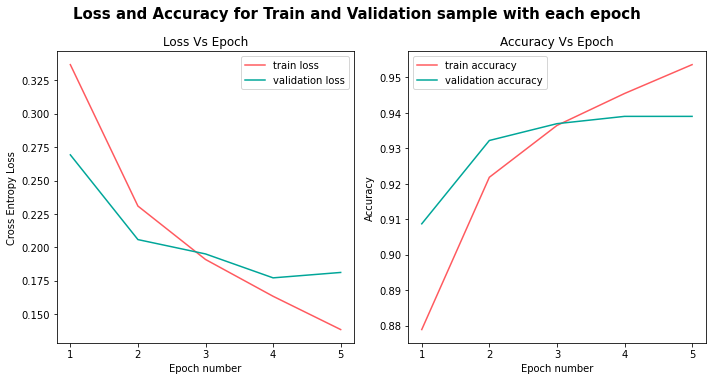

In [ ]:
### Plot the graphs
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(df['epochs'], df['loss'], color = '#FF5A5F')
ax[0].plot(df['epochs'], df['val_loss'], color = '#00A699')
ax[0].legend(['train loss', 'validation loss'])
ax[0].set(xlabel="Epoch number", ylabel="Cross Entropy Loss")
ax[0].set_title('Loss Vs Epoch')

ax[1].plot(df['epochs'],df['accuracy'],color = '#FF5A5F')
ax[1].plot(df['epochs'], df['val_accuracy'],color = '#00A699')
ax[1].legend(['train accuracy', 'validation accuracy'])
ax[1].set(xlabel="Epoch number", ylabel="Accuracy")
ax[1].set_title('Accuracy Vs Epoch')

fig.suptitle('Loss and Accuracy for Train and Validation sample with each epoch', fontsize = 15, fontweight = 'bold', y = 1.05)
fig.tight_layout()
plt.show()

#### Failure Analysis: Look at some of the incorrect predictions to explore possible reasons for the wrong prediction

In [ ]:
### Get the predicted flag for the test data and merge it to the test dataframe
y_pred = [np.argmax(y_pred[i]) for i in range(len(y_pred))]

test_df['predicted_label'] = y_pred





In [ ]:
####Lets look at some positive feedbacks which were wrongly predicted as negative
positive_wrong_pred = test_df[(test_df.label == 2) & (test_df.predicted_label != 2)][['cleaned_comments_LSTM','predicted_label']]
positive_wrong_pred.to_csv('wrong_preds.csv')


In [ ]:
####Lets look at some negative feedbacks which were wrongly predicted as positive
negative_wrong_pred = test_df[(test_df.label == 0) & (test_df.predicted_label == 2)][['cleaned_comments_LSTM','predicted_label']]
negative_wrong_pred.to_csv('wrong_preds_negative.csv')


### End of Deep Learning code